### About the dataset

The dataset contains the following information of 30000 customers:

DEFAULT - Default payment next month (Yes=1, No=0)

LIMIT_BAL - Amount of the given credit (INR)

SEX - Gender (1 = male; 2 = female)

EDUCATION - Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

MARRIAGE - (1 = married; 2 = single; 3 = others)

AGE - (year)

PAY - History of repayment status

- PAY1 = the repayment status in September 2005
- PAY2 = the repayment status in August 2005 ....
- PAY6 = the repayment status in April 2005
- The measurement scale for the repayment status is:

  i. - 1 = pay duly <br>
  ii. 1 = payment delay for one month<br>
  iii. 2 = payment delay for two months <br>
  iv. 8 = payment delay for eight months<br>
  v. 9 = payment delay for nine months and above <br>

BILL_AMT- Amount of bill statement (INR)

- BILL_AMT1 = amount of bill statement in September 2005
- BILL_AMT2 = amount of bill statement in August 2005....
- BILL_AMT6 = amount of bill statement in April 2005

PAY_AMT - Amount of previous payment (INR)

- PAY_AMT1 = amount paid in September 2005
- PAY_AMT2 = amount paid in August 2005....
- PAY_AMT6 = amount paid in April 2005

### Additional information

- The difference between the bill amount and the past pay for a month will give an indication of the pending amount for each month and can be used as an additional X variable

- The average / sum of bill amount can be used as an additional X variable which will give an indication on the customer value.


In [403]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings

warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    ConfusionMatrixDisplay,

)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint as sp_randint
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [404]:
df = pd.read_csv("res/UCI_Credit_Card.csv")
df.rename(
    columns={"PAY_0": "PAY_1", "default.payment.next.month": "def_pay"}, inplace=True
)
df.drop(["ID"], axis=1, inplace=True)
data = df.copy()

df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [405]:
df.shape

(30000, 24)

In [406]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_1      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

In [407]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


In [408]:
df.isnull().sum().sum()

0

In [409]:
cols = df.columns.to_list()
cols

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'def_pay']

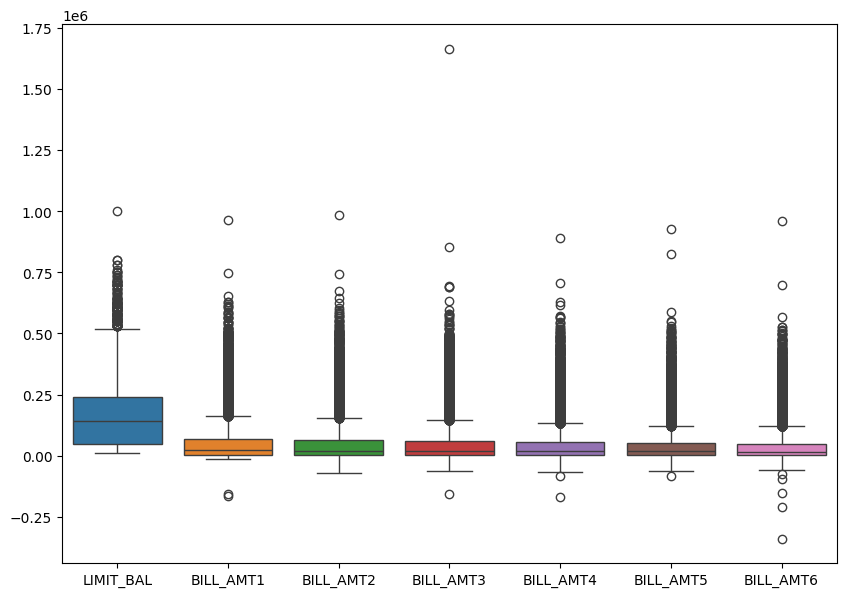

In [410]:
# boxplot for bill_Amt and limit_bal

plt.figure(figsize=(10, 7))
sns.boxplot(
    data=df[
        [
            "LIMIT_BAL",
            "BILL_AMT1",
            "BILL_AMT2",
            "BILL_AMT3",
            "BILL_AMT4",
            "BILL_AMT5",
            "BILL_AMT6",
        ]
    ]
)

plt.show()

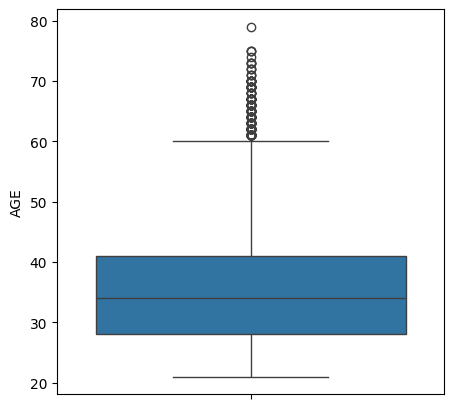

In [411]:
# Boxplot for column 'AGE'
plt.figure(figsize=(5, 5))
sns.boxplot(data=df["AGE"])
plt.show()

In [412]:
# Outliers on numerical Columns
num_var = df.select_dtypes(exclude="object")
for i in num_var:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)

    IQR = q3 - q1
    UL = q3 + 1.5 * IQR
    LL = q1 - 1.5 * IQR

    print("IQR of", i, "= ", IQR)
    print("UL of", i, "= ", UL)
    print("LL of", i, "= ", LL)
    print(
        f"Number of Outliers in {i} = {(df.shape[0] - df[(df[i] < UL) & (df[i] > LL)].shape[0])}"
    )
    print(" ")

IQR of LIMIT_BAL =  190000.0
UL of LIMIT_BAL =  525000.0
LL of LIMIT_BAL =  -235000.0
Number of Outliers in LIMIT_BAL = 167
 
IQR of SEX =  1.0
UL of SEX =  3.5
LL of SEX =  -0.5
Number of Outliers in SEX = 0
 
IQR of EDUCATION =  1.0
UL of EDUCATION =  3.5
LL of EDUCATION =  -0.5
Number of Outliers in EDUCATION = 454
 
IQR of MARRIAGE =  1.0
UL of MARRIAGE =  3.5
LL of MARRIAGE =  -0.5
Number of Outliers in MARRIAGE = 0
 
IQR of AGE =  13.0
UL of AGE =  60.5
LL of AGE =  8.5
Number of Outliers in AGE = 272
 
IQR of PAY_1 =  1.0
UL of PAY_1 =  1.5
LL of PAY_1 =  -2.5
Number of Outliers in PAY_1 = 3130
 
IQR of PAY_2 =  1.0
UL of PAY_2 =  1.5
LL of PAY_2 =  -2.5
Number of Outliers in PAY_2 = 4410
 
IQR of PAY_3 =  1.0
UL of PAY_3 =  1.5
LL of PAY_3 =  -2.5
Number of Outliers in PAY_3 = 4209
 
IQR of PAY_4 =  1.0
UL of PAY_4 =  1.5
LL of PAY_4 =  -2.5
Number of Outliers in PAY_4 = 3508
 
IQR of PAY_5 =  1.0
UL of PAY_5 =  1.5
LL of PAY_5 =  -2.5
Number of Outliers in PAY_5 = 2968
 
IQR o

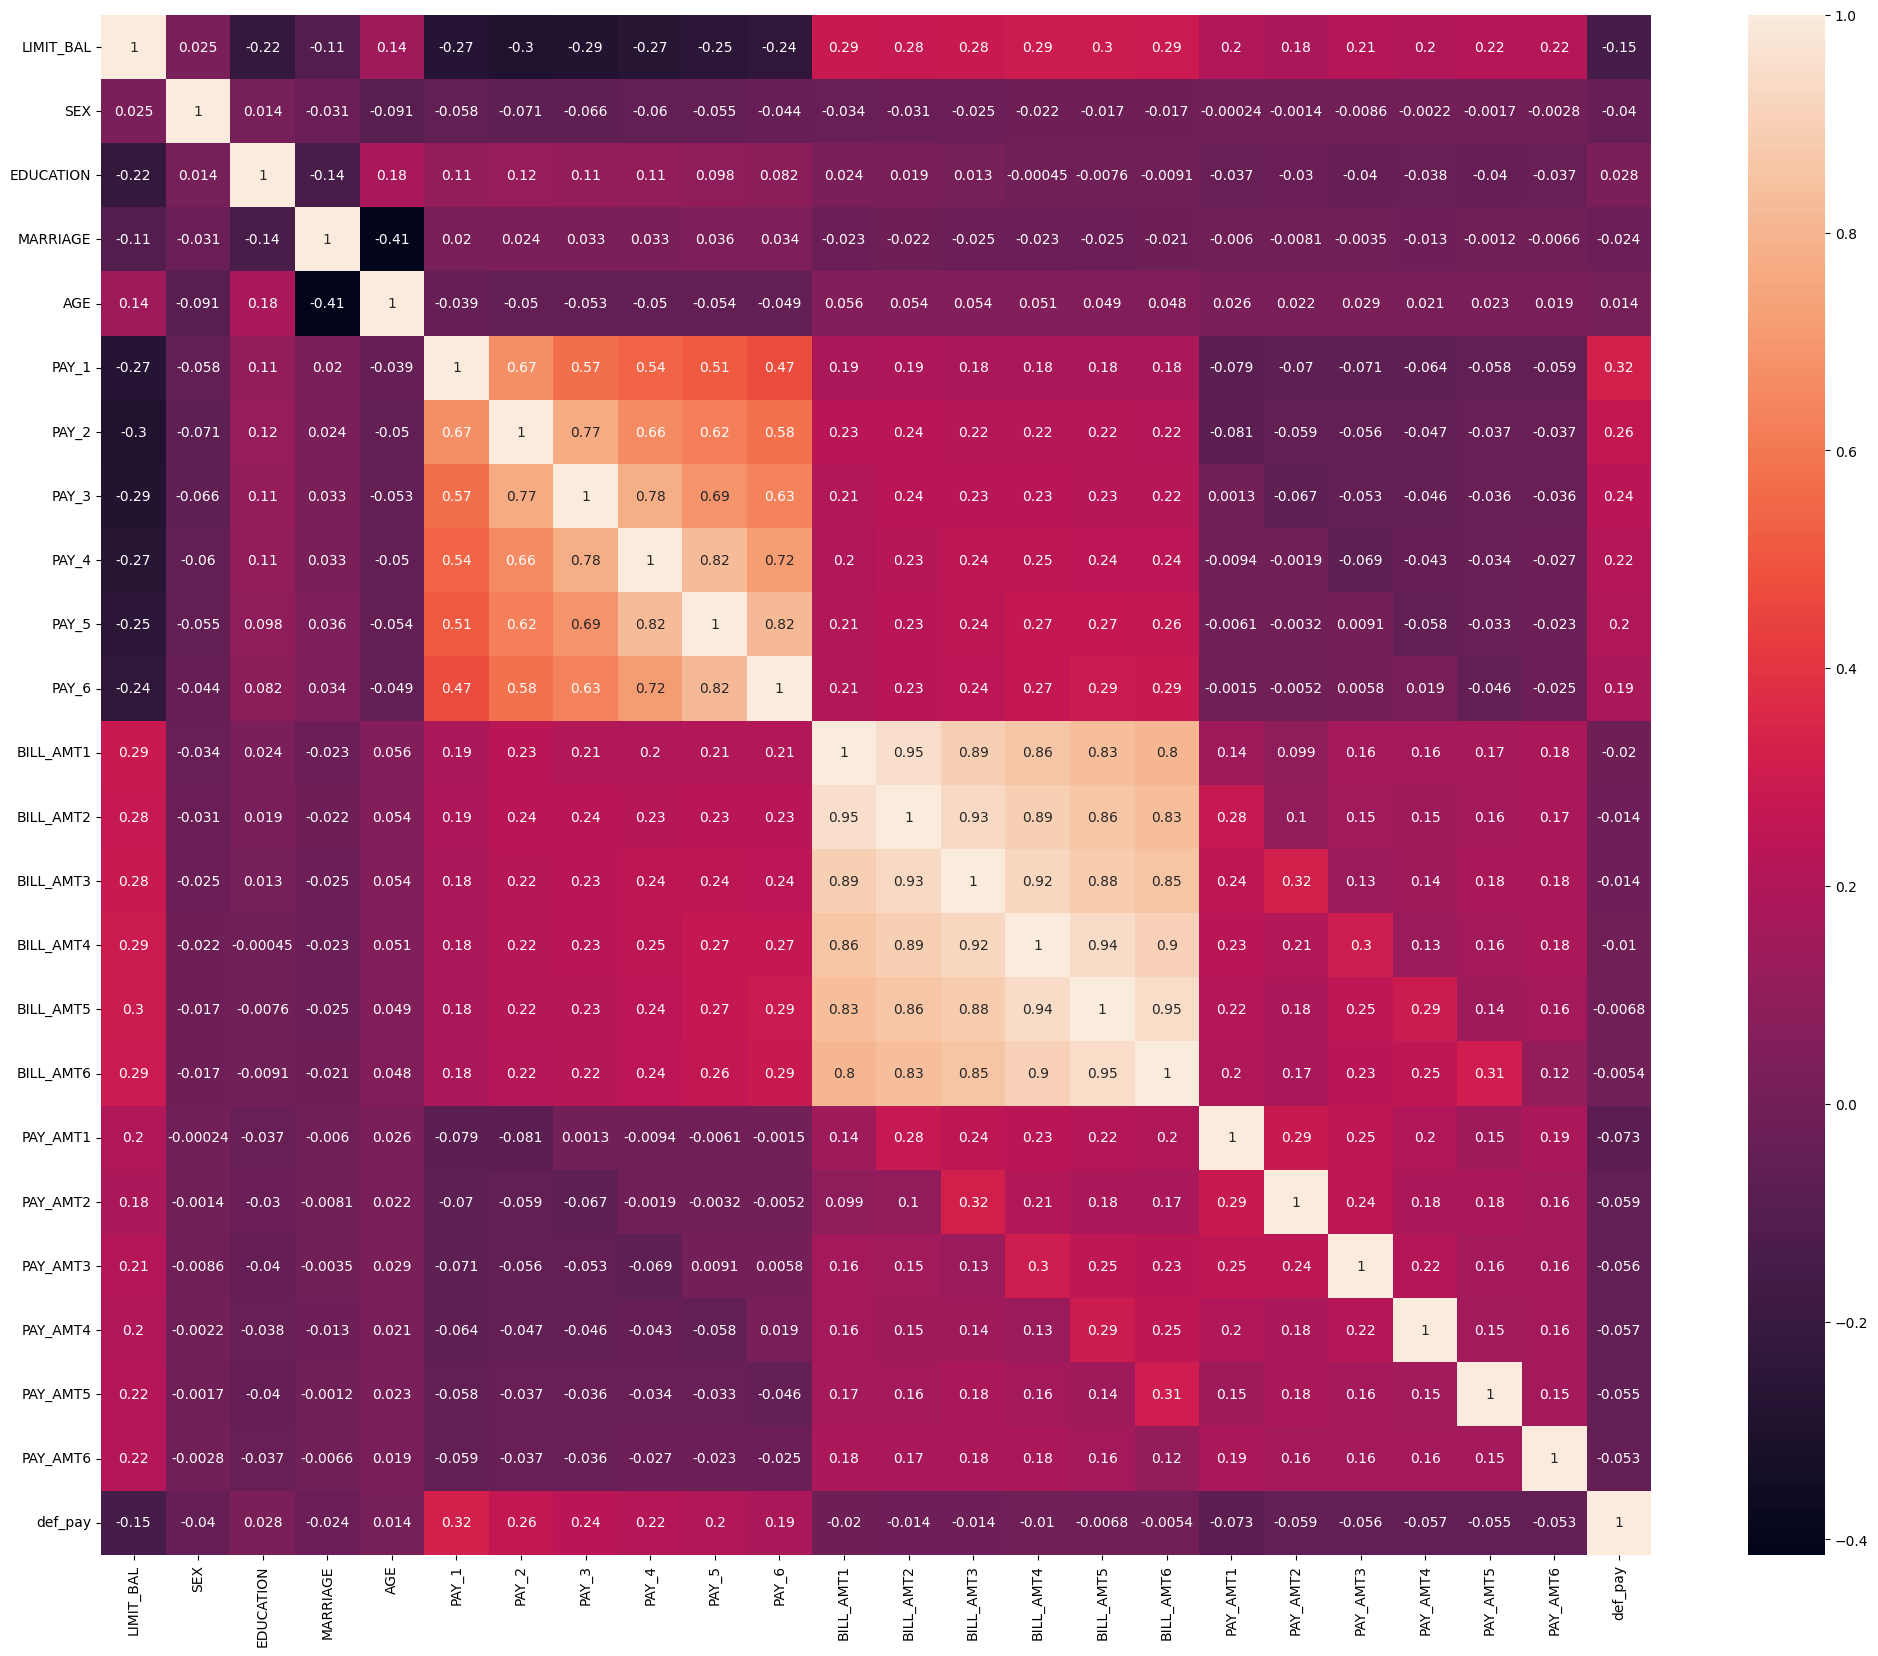

In [413]:
# Checking correlation
plt.figure(figsize=(25, 20))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [414]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


def_pay
0    77.88
1    22.12
Name: count, dtype: float64


<Axes: xlabel='def_pay', ylabel='Count'>

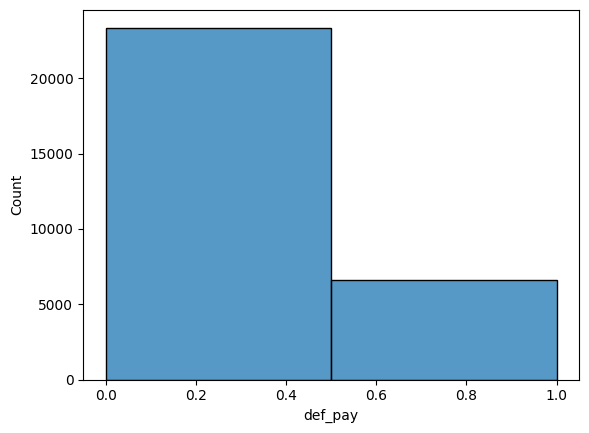

In [415]:
print(
    (
        df["def_pay"].value_counts()
        / df["def_pay"].shape
    )
    * 100
)
# sns.countplot(df['def_pay'])
sns.histplot(df["def_pay"], bins=2)
# plt.show()

In [416]:
# BaseLine modeling

# Splitting
X_base = df.drop("def_pay", axis=1)
y_base = df["def_pay"]

# Train_test_split
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_base, y_base, test_size=0.3, random_state=2
)

# defining a Logistic regression baseline model
logreg_base = LogisticRegression(solver="liblinear", fit_intercept=True)
logreg_base.fit(X_train_base, y_train_base)

y_pred_base = logreg_base.predict(X_test_base)
print(
    "Classification report - Test: ",
    "\n",
    classification_report(y_test_base, y_pred_base),
)

Classification report - Test:  
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      7006
           1       0.00      0.00      0.00      1994

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.61      0.78      0.68      9000



### Inferences:

- Model is completely biased towards class 0, and fails to predict class 1 at all... but a good baseline to improve upon


In [417]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_tmp = df.drop(["def_pay"], axis=1)
vif = pd.DataFrame()

vif["Features"] = df_tmp.columns
vif["vif"] = [variance_inflation_factor(df_tmp.values, i) for i in range(df_tmp.shape[1])]

vif

,Features,vif
0,LIMIT_BAL,4.037479
1,SEX,9.092210
2,EDUCATION,6.731119
3,MARRIAGE,6.265388
4,AGE,10.857679
5,PAY_1,1.918276
6,PAY_2,3.211217
7,PAY_3,3.727427
8,PAY_4,4.440120
9,PAY_5,4.985856


In [418]:
# Calculate the ratio of PAY_AMT to BILL_AMT for each month
pay_bill_ratio = (
    ((data["PAY_AMT1"]) / (data["BILL_AMT1"]+1e-4)) +
    ((data["PAY_AMT2"]) / (data["BILL_AMT2"]+1e-4)) +
    ((data["PAY_AMT3"]) / (data["BILL_AMT3"]+1e-4)) +
    ((data["PAY_AMT4"]) / (data["BILL_AMT4"]+1e-4)) +
    ((data["PAY_AMT5"]) / (data["BILL_AMT5"]+1e-4)) +
    ((data["PAY_AMT6"]) / (data["BILL_AMT6"]+1e-4))
)

# Add the ratio as a new column to the dataframe
data["PAY_BILL_RATIO"] = pay_bill_ratio

# If you wish to keep 'def_pay' and just need to drop the original columns, do so here:
df = data.drop(
    [
        "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
        "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"
    ],
    axis=1
)

# Show the first few rows to confirm
df.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,1,0.222115
1,120000.0,2,2,2,26,-1,2,0,0,0,2,1,1.871498
2,90000.0,2,2,2,34,0,0,0,0,0,0,0,0.690847
3,50000.0,2,2,1,37,0,0,0,0,0,0,0,0.218375
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,0,7.481746


In [419]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,1,0.222115
1,120000.0,2,2,2,26,-1,2,0,0,0,2,1,1.871498
2,90000.0,2,2,2,34,0,0,0,0,0,0,0,0.690847
3,50000.0,2,2,1,37,0,0,0,0,0,0,0,0.218375
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,0,7.481746


## Now doing some feature engineering


In [420]:
def bin_pays(x):
    """Binning the 'PAY' Columns"""
    if x <= 0:
        return "Paid Duly"
    elif x in range(1, 4):
        return "1 to 3"
    elif x in range(4, 7):
        return "4 to 6"
    elif x in range(7, 9):
        return "7 to 9"


def fix_education(x):
    if x in [0, 4, 5, 6]:
        return 4
    else:
        return x

# Define bins and labels
bins = [20, 27, 32, 37, 42, 48, 58, 64, 80]
labels = [8, 7, 6, 5, 4, 3, 2, 1]

# Bin the AGE column
df["AGE_GROUP"] = pd.cut(df["AGE"], bins=bins, labels=labels)

df["EDUCATION"] = df["EDUCATION"].apply(fix_education)

for i in df[["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]]:
    df[i] = df[i].apply(bin_pays)

print(f"Dataset after Feature Engineering: \n")
df.head()

Dataset after Feature Engineering: 



,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO,AGE_GROUP
0,20000.0,2,2,1,24,1 to 3,1 to 3,Paid Duly,Paid Duly,Paid Duly,Paid Duly,1,0.222115,8
1,120000.0,2,2,2,26,Paid Duly,1 to 3,Paid Duly,Paid Duly,Paid Duly,1 to 3,1,1.871498,8
2,90000.0,2,2,2,34,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,0,0.690847,6
3,50000.0,2,2,1,37,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,0,0.218375,6
4,50000.0,1,2,1,57,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,0,7.481746,3


In [421]:
df.drop(["AGE"], axis=1, inplace=True)
df.rename(columns={'AGE_GROUP':'AGE'}, inplace=True)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

# Define the expected categories for PAY columns
expected_pay_categories = ["Paid Duly", "1 to 3", "4 to 6", "7 to 9"]

# Ensure each PAY column has the same categories for encoding
pay_columns = [col for col in df.columns if "PAY_" in col]

# Apply Ordinal Encoding
oe = OrdinalEncoder(categories=[expected_pay_categories] * len(pay_columns))  # Same categories for each PAY column

# Apply Ordinal Encoding to the PAY columns
df[pay_columns] = oe.fit_transform(df[pay_columns])

# Display the transformed DataFrame
df.head()


In [427]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

# Instantiate the encoders
le = LabelEncoder()  # For Label Encoding (for non-ordinal categories)
oe = OrdinalEncoder()  # For Ordinal Encoding (for ordinal categories)

# Specify the PAY columns and other categorical columns
pay_columns = [col for col in df.columns if "PAY_" in col]
categorical_columns = df.select_dtypes(include=object).columns.tolist()

# oe = OrdinalEncoder(categories=[["Paid Duly", "1 to 3", "4 to 6", "7 to 9"]])
# Apply Ordinal Encoding to the PAY columns
df[pay_columns] = oe.fit_transform(df[pay_columns])

# Apply Label Encoding to other categorical columns (excluding PAY columns)
other_categorical_columns = [
    col for col in categorical_columns if col not in pay_columns
]
for col in other_categorical_columns:
    df[col] = le.fit_transform(df[col])

# Display the first few rows to check the result
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO,AGE
0,20000.0,2,2,1,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0,8
1,120000.0,2,2,2,0.0,1.0,0.0,0.0,0.0,1.0,1,0.0,8
2,90000.0,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,6
3,50000.0,2,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,6
4,50000.0,1,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,3


In [368]:
# # Encoding Categorical Variables
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()

# for col in df.select_dtypes(include=object).columns:
#     df[col] = le.fit_transform(df[col])

# df.head()

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import pandas as pd

# # Select the PAY_AMT columns
# pay_columns = ['PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# # Standardize the data (important for PCA)
# scaler = StandardScaler()
# pay_scaled = scaler.fit_transform(df[pay_columns])

# # Apply PCA
# pca = PCA(n_components=1)  # Reduce to 1 principal component
# pay_pca = pca.fit_transform(pay_scaled)

# # Add the PCA result as a new column
# df['PAY_PCA'] = pay_pca

# # Optionally, drop the original PAY_AMT columns
# df = df.drop(columns=pay_columns)

# # Show the updated dataframe with the new PCA feature
# df.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,PAY_1,def_pay,PAY_BILL_RATIO,AGE,PAY_PCA
0,20000.0,2,2,1,0.0,1,4654.0,8,-0.355538
1,120000.0,2,2,2,3.0,1,17805.0,8,-1.774834
2,90000.0,2,2,2,3.0,0,15293.0,6,0.822460
3,50000.0,2,2,1,3.0,0,4295.0,6,0.822460
4,50000.0,1,2,1,3.0,0,21134.0,3,0.822460


In [370]:
# Splitting into dependant and independant variables
X = df.drop("def_pay", axis=1)
y = df["def_pay"]

In [371]:
X.isna().sum()

LIMIT_BAL         0
SEX               0
EDUCATION         0
MARRIAGE          0
PAY_1             0
PAY_BILL_RATIO    0
AGE               0
PAY_PCA           0
dtype: int64

In [372]:
from sklearn.preprocessing import StandardScaler

X = df.drop(["def_pay"], axis=1)
y = df["def_pay"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1
)
sc = StandardScaler()
X_train_sc = X_train
X_test_sc = X_test
# X_train_sc = sc.fit_transform(X_train_sc)
# X_test_sc = sc.transform(X_test_sc)

In [373]:
X_train_sc

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_BILL_RATIO,AGE,PAY_PCA
28004,20000.0,2,2,2,0.0,18719.0,7,-0.355538
8560,50000.0,2,2,1,3.0,20318.0,7,0.822460
15484,180000.0,1,1,1,0.0,1149.0,6,0.822460
12531,20000.0,2,2,2,3.0,26122.0,3,0.822460
24473,340000.0,1,1,2,3.0,21964.0,3,0.822460
...,...,...,...,...,...,...,...,...
17289,170000.0,2,3,1,0.0,28037.0,5,-0.355538
5192,330000.0,2,1,1,3.0,1149.0,5,0.822460
12172,50000.0,1,2,2,3.0,3321.0,8,0.822460
235,80000.0,1,1,2,3.0,23435.0,6,0.822460


In [374]:
def res(y_test_valid, y_train_valid):
    cm_log = confusion_matrix(y_test, y_test_valid)
    ConfusionMatrixDisplay(cm_log).plot()
    
    print(f"f1_score = {f1_score(y_test, y_test_valid)}")
    
    print(classification_report(y_test, y_test_valid))
    
    print("train_accuracy:", accuracy_score(y_train, y_train_valid))
    print("test_accuracy:", accuracy_score(y_test, y_test_valid))

f1_score = 0.3932878867330886
              precision    recall  f1-score   support

           0       0.82      0.96      0.89      4663
           1       0.66      0.28      0.39      1337

    accuracy                           0.81      6000
   macro avg       0.74      0.62      0.64      6000
weighted avg       0.79      0.81      0.78      6000

train_accuracy: 0.8062916666666666
test_accuracy: 0.8071666666666667


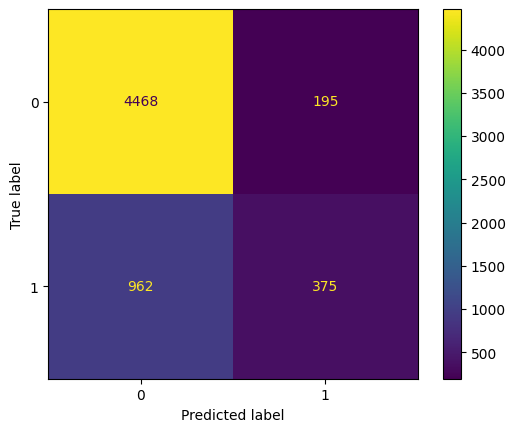

In [375]:
log_model = LogisticRegression()
log_model.fit(X_train_sc, y_train)
y_pred_log = log_model.predict(X_test_sc)
y_pred_train = log_model.predict(X_train_sc)
res(y_pred_log, y_pred_train)

f1_score = 0.39604989604989604
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      4663
           1       0.65      0.28      0.40      1337

    accuracy                           0.81      6000
   macro avg       0.74      0.62      0.64      6000
weighted avg       0.78      0.81      0.78      6000

train_accuracy: 0.8099583333333333
test_accuracy: 0.8063333333333333


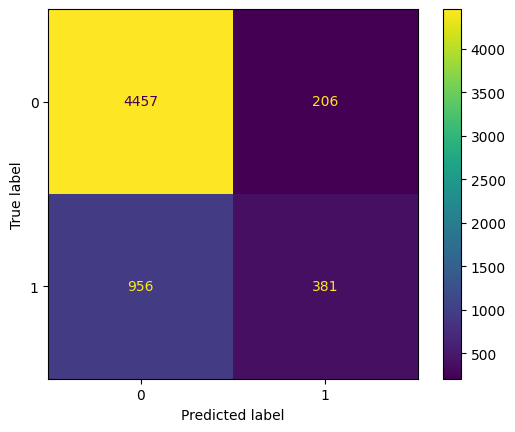

In [376]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3
)
rf_model.fit(X_train_sc, y_train)
y_pred_rf = rf_model.predict(X_test_sc)
y_pred_rf_train = rf_model.predict(X_train_sc)
res(y_pred_rf, y_pred_rf_train)


LIMIT_BAL: 0.0750
SEX: 0.0032
EDUCATION: 0.0086
MARRIAGE: 0.0041
PAY_1: 0.4754
PAY_BILL_RATIO: 0.0846
AGE: 0.0067
PAY_PCA: 0.3424


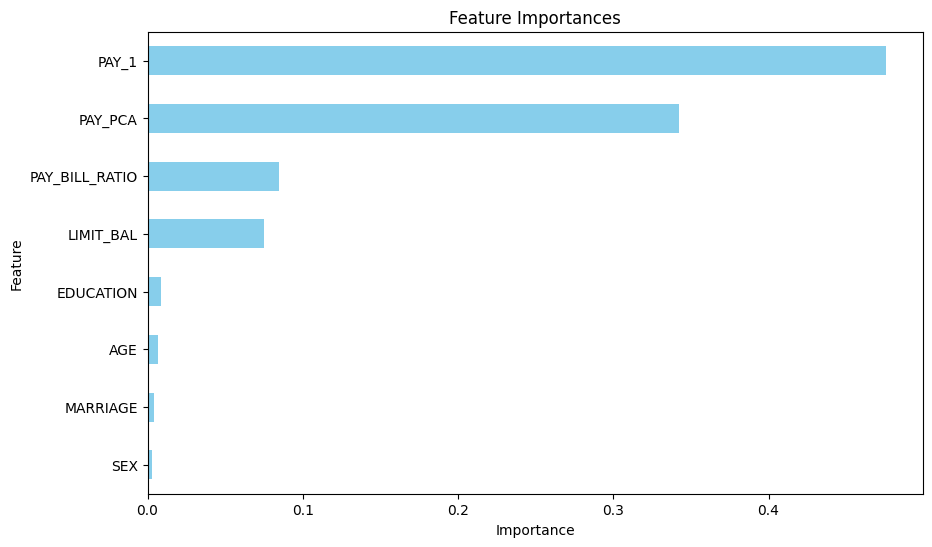

In [377]:
importances = rf_model.feature_importances_

# Loop through feature names and their corresponding importance values
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance:.4f}")

# Remove the ID
# Create a DataFrame for easy plotting
importances_df = pd.Series(importances, index=X_train.columns)

# Plot the feature importances
plt.figure(figsize=(10, 6))
importances_df.sort_values().plot(kind="barh", color="skyblue")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [378]:
corr_matrix = df.corr()

# Create a mask to find pairs with a high correlation (e.g., > 0.9)

# TODO: Correlation higher values: [0.75, 0.8]
mask = (corr_matrix > 0.75) & (corr_matrix < 1.0)

# Get pairs of correlated features
highly_correlated_pairs = corr_matrix[mask]

# Drop one of each pair (for simplicity, we'll drop the second feature in each pair)
features_to_drop = []


for feature in highly_correlated_pairs.columns:
    correlated_features = highly_correlated_pairs[feature].dropna().index.tolist()
    features_to_drop.extend(correlated_features[1:])

df_filtered = df.drop(columns=features_to_drop)

In [379]:
df_filtered.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,PAY_1,def_pay,PAY_BILL_RATIO,AGE,PAY_PCA
0,20000.0,2,2,1,0.0,1,4654.0,8,-0.355538
1,120000.0,2,2,2,3.0,1,17805.0,8,-1.774834
2,90000.0,2,2,2,3.0,0,15293.0,6,0.822460
3,50000.0,2,2,1,3.0,0,4295.0,6,0.822460
4,50000.0,1,2,1,3.0,0,21134.0,3,0.822460


In [380]:
# Splitting into dependant and independant variables
X = df_filtered.drop("def_pay", axis=1)
y = df_filtered["def_pay"]

In [381]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Identify important features
important_features = [
    feature for feature, importance in zip(X.columns, importances) if importance > 0.03
]

# Apply scaling only to important features
# scaler = StandardScaler()
X_transformed_df = X

f1_score = 0.4468503937007874
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4663
           1       0.65      0.34      0.45      1337

    accuracy                           0.81      6000
   macro avg       0.74      0.64      0.67      6000
weighted avg       0.79      0.81      0.79      6000

train_accuracy: 0.8141666666666667
test_accuracy: 0.8126666666666666
LIMIT_BAL: 0.0583
PAY_1: 0.4876
PAY_BILL_RATIO: 0.0908
PAY_PCA: 0.3633


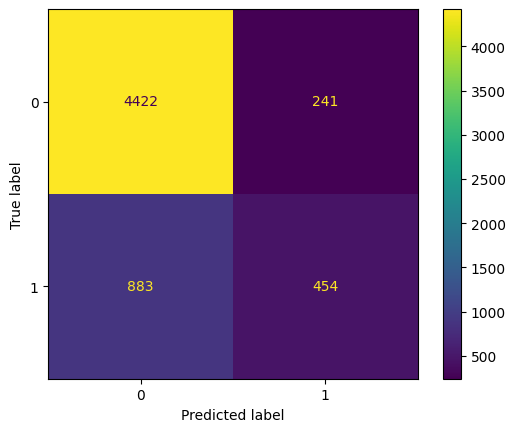

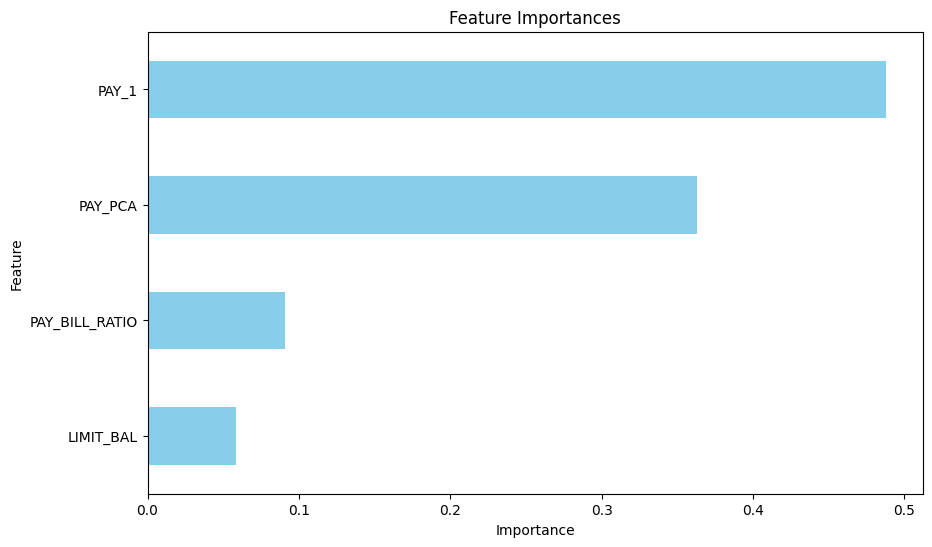

In [382]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X[important_features], y, test_size=0.20, random_state=1
)
sc = StandardScaler()
X_train_sc = X_train
X_test_sc = X_test
# X_train_sc = sc.fit_transform(X_train_sc)
# X_test_sc = sc.transform(X_test_sc)
rf_model = RandomForestClassifier(
    n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3
)
rf_model.fit(X_train_sc, y_train)
y_pred_rf = rf_model.predict(X_test_sc)
y_pred_rf_train = rf_model.predict(X_train_sc)
res(y_pred_rf, y_pred_rf_train)

importances = rf_model.feature_importances_

# Loop through feature names and their corresponding importance values
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance:.4f}")

# Remove the ID
# Create a DataFrame for easy plotting
importances_df = pd.Series(importances, index=X_train.columns)

# Plot the feature importances
plt.figure(figsize=(10, 6))
importances_df.sort_values().plot(kind="barh", color="skyblue")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [383]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_tmp = df.drop(["def_pay"], axis=1)
vif = pd.DataFrame()

vif["Features"] = df_tmp.columns
vif["vif"] = [variance_inflation_factor(df_tmp.values, i) for i in range(df_tmp.shape[1])]

vif

,Features,vif
0,LIMIT_BAL,2.700976
1,SEX,10.065243
2,EDUCATION,5.559588
3,MARRIAGE,10.914791
4,PAY_1,5.750016
5,PAY_BILL_RATIO,3.670569
6,AGE,14.448749
7,PAY_PCA,1.360265


In [384]:
important_features

['LIMIT_BAL', 'PAY_1', 'PAY_BILL_RATIO', 'PAY_PCA']

Previous shapes: (24000, 4), (24000,)
Resampled Shape: (37398, 4), (37398,)
def_pay
0    50.0
1    50.0
Name: count, dtype: float64


<Axes: xlabel='def_pay', ylabel='Count'>

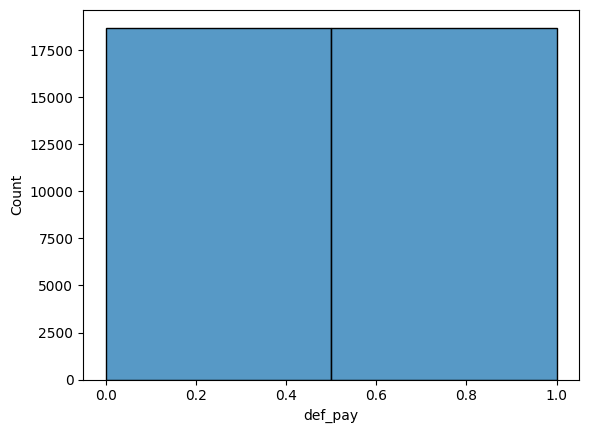

In [ ]:
# Creating global x_test:
X_train_glob, X_test, y_train_glob, y_test = train_test_split(X_transformed_df[important_features], y, test_size=0.2, random_state=2)

# Now handle imbalance in data using SMOTE only for the important features
# SMOTEEN 
smote = SMOTE(sampling_strategy='auto', random_state=2)

X_train_glob = sc.fit_transform(X_train_glob)
X_test = sc.fit_transform(X_test)

X_resampled, y_resampled = smote.fit_resample(X_train_glob, y_train_glob)

# New shape:
print(f"Previous shapes: {X_train_glob.shape}, {y_train_glob.shape}")
print(f"Resampled Shape: {X_resampled.shape}, {y_resampled.shape}")

print((y_resampled.value_counts() / y_resampled.shape) * 100)
sns.histplot(y_resampled, bins=2)


In [386]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Define models to test
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": lgb.LGBMClassifier(),
}

# Define parameter distributions
param_distributions = {
    "Random Forest": {
        "n_estimators": randint(100, 500),
        "max_depth": [None, 10, 20],
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 20),
        "bootstrap": [True, False],
    },
    "Logistic Regression": {
        "C": uniform(0.01, 100),
        "penalty": ["l2"],
        "solver": ["lbfgs", "liblinear"],
        "max_iter": [100, 200],
    },
    "Gradient Boosting": {
        "n_estimators": randint(100, 500),
        "learning_rate": uniform(0.01, 0.5),
        "max_depth": randint(3, 7),
        "subsample": uniform(0.5, 0.5),  # Ensures values between 0.5 and 1.0
        "min_samples_split": randint(2, 10),
    },
    "XGBoost": {  # Add XGBoost parameters
        "n_estimators": randint(100, 500),
        "learning_rate": uniform(0.01, 0.3),
        "max_depth": randint(3, 7),
        "subsample": uniform(0.5, 0.5),  # Ensures values between 0.5 and 1.0
        "colsample_bytree": uniform(0.5, 1.0),
        "min_child_weight": randint(1, 10),
    },
    "LightGBM": {  # Add LightGBM parameters
        "n_estimators": randint(100, 500),
        "learning_rate": uniform(0.01, 0.3),
        "max_depth": randint(3, 7),
        "num_leaves": randint(20, 100),
        "subsample": uniform(0.5, 0.5),  # Ensures values between 0.5 and 1.0
        "colsample_bytree": uniform(0.5, 1.0),  # Ensures values between 0.5 and 1.0
    },
}

results = {}

# Splitting dataset into training and validation sets (modify as per your dataset)
# Assuming X_resampled and y_resampled are your features and target labels after balancing
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=2
)

# Running RandomizedSearchCV for all models
for model_name, model in models.items():
    print(f"Running RandomizedSearchCV for {model_name}...")

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[model_name],
        n_iter=5,  # Number of random combinations to try
        cv=5,  # 5-fold cross-validation
        n_jobs=1,  # Set to 1 (for single-core) or -1 (for multi-core parallelism)
        verbose=1,
        scoring="accuracy",
        random_state=2,  # Ensure reproducibility
    )

    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_
    print(f"Best Parameters for {model_name}: {best_params}")

    # Predictions
    y_pred = best_model.predict(X_val)
    y_pred_prob = best_model.predict_proba(X_val)[:, 1]  # Probabilities for ROC AUC and Log-Loss

    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    log_loss_score = log_loss(y_val, y_pred_prob)

    # Store results
    results[model_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "log_loss": log_loss_score,
        "best_params": best_params,
    }

    # Print results for the model
    print(f"{model_name} - Accuracy: {accuracy:.4f}")
    print(f"{model_name} - Precision: {precision:.4f}")
    print(f"{model_name} - Recall: {recall:.4f}")
    print(f"{model_name} - F1-Score: {f1:.4f}")
    print(f"{model_name} - ROC AUC: {roc_auc:.4f}")
    print(f"{model_name} - Log Loss: {log_loss_score:.4f}")
    print(f"{model_name} - Classification Report:\n{classification_report(y_val, y_pred)}")
    print(f"{model_name} - Confusion Matrix:\n{confusion_matrix(y_val, y_pred)}\n")


Running RandomizedSearchCV for Logistic Regression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters for Logistic Regression: {'C': 54.97624778787091, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression - Accuracy: 0.6984
Logistic Regression - Precision: 0.7661
Logistic Regression - Recall: 0.5657
Logistic Regression - F1-Score: 0.6508
Logistic Regression - ROC AUC: 0.7516
Logistic Regression - Log Loss: 0.5883
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.83      0.73      5645
           1       0.77      0.57      0.65      5575

    accuracy                           0.70     11220
   macro avg       0.71      0.70      0.69     11220
weighted avg       0.71      0.70      0.69     11220

Logistic Regression - Confusion Matrix:
[[4682  963]
 [2421 3154]]

Running RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 5 candidates, t

In [390]:
# After all models are trained, you can print the best performing model
best_model_name = max(results, key=lambda model_name: results[model_name]["f1_score"])
best_model = results[best_model_name]
print(
    f"The best performing model is {best_model_name} with an f1_score of {best_model['f1_score']:.4f}"
)

# Use the best model on the test set
print(f"Evaluating the best model ({best_model_name}) on the test set...")

# Best model selected from RandomizedSearchCV
final_model = results[best_model_name]["best_params"]

# Predictions on test data
y_test_pred = random_search.best_estimator_.predict(X_test)
y_test_pred_prob = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate metrics on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_log_loss = log_loss(y_test, y_test_pred_prob)

# Classification report and confusion matrix
test_classification_rep = classification_report(y_test, y_test_pred)
test_confusion_mat = confusion_matrix(y_test, y_test_pred)

# Print final metrics
print("Final Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"Log Loss: {test_log_loss:.4f}")
print("Classification Report:\n", test_classification_rep)
print("Confusion Matrix:\n", test_confusion_mat)

The best performing model is Gradient Boosting with an f1_score of 0.7550
Evaluating the best model (Gradient Boosting) on the test set...
Final Test Metrics:
Accuracy: 0.5265
Precision: 0.2971
Recall: 0.8262
F1-Score: 0.4371
ROC AUC: 0.7372
Log Loss: 0.8417
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.44      0.59      4665
           1       0.30      0.83      0.44      1335

    accuracy                           0.53      6000
   macro avg       0.60      0.63      0.51      6000
weighted avg       0.76      0.53      0.56      6000

Confusion Matrix:
 [[2056 2609]
 [ 232 1103]]


In [402]:
# Set the threshold (you can experiment with different values, such as 0.3, 0.4, or 0.5)
threshold = (0.74)  # Example threshold for an imbalanced dataset (adjust based on tuning)

# Convert predicted probabilities to binary predictions based on the new threshold
y_test_pred_adjusted = (y_test_pred_prob >= threshold).astype(int)

# Calculate metrics with the adjusted threshold
test_accuracy = accuracy_score(y_test, y_test_pred_adjusted)
test_precision = precision_score(y_test, y_test_pred_adjusted)
test_recall = recall_score(y_test, y_test_pred_adjusted)
test_f1 = f1_score(y_test, y_test_pred_adjusted)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_log_loss = log_loss(y_test, y_test_pred_prob)

# Classification report and confusion matrix
test_classification_rep = classification_report(y_test, y_test_pred_adjusted)
test_confusion_mat = confusion_matrix(y_test, y_test_pred_adjusted)

# Print final metrics
print("Final Test Metrics with threshold =", threshold)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"Log Loss: {test_log_loss:.4f}")
print("Classification Report:\n", test_classification_rep)
print("Confusion Matrix:\n", test_confusion_mat)


Final Test Metrics with threshold = 0.74
Accuracy: 0.7272
Precision: 0.4230
Recall: 0.6217
F1-Score: 0.5035
ROC AUC: 0.7372
Log Loss: 0.8417
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81      4665
           1       0.42      0.62      0.50      1335

    accuracy                           0.73      6000
   macro avg       0.65      0.69      0.66      6000
weighted avg       0.77      0.73      0.74      6000

Confusion Matrix:
 [[3533 1132]
 [ 505  830]]


f1_score = 0.5207064555420219
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      4665
           1       0.44      0.64      0.52      1335

    accuracy                           0.74      6000
   macro avg       0.66      0.70      0.67      6000
weighted avg       0.78      0.74      0.75      6000

train_accuracy: 0.7164412865765146
test_accuracy: 0.7376666666666667


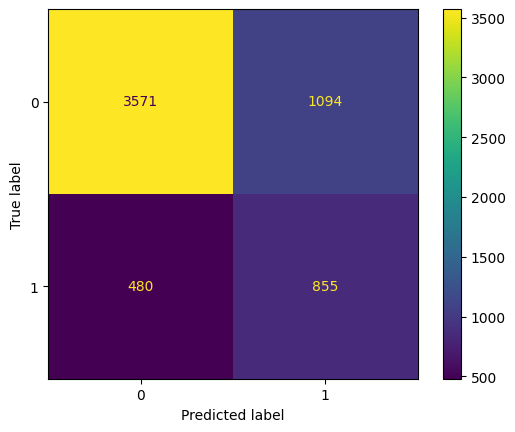

In [392]:
rf_model_smote = RandomForestClassifier(
    n_estimators=70,
    max_depth=5,
    min_samples_leaf=4,
    min_samples_split=3,
    random_state=1,
)
rf_model_smote.fit(X_train, y_train)
y_pred_rf_smote = rf_model_smote.predict(X_test)
y_pred_rf_smote_train = rf_model_smote.predict(X_train)

res(y_pred_rf_smote, y_pred_rf_smote_train)